In [1]:
# Start writin#Librerías para manejo de datos
import pandas as pd
import numpy as np

#Librerías para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para modelar
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import PAIRWISE_DISTANCE_FUNCTIONS
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC

In [ ]:
df = pd.read_csv('/data/properati_argentina_2021_filtrado.csv')
df_pca = pd.read_csv('/data/properati_argentina_2021_pca.csv')

# 4)Regresión

<AxesSubplot: >

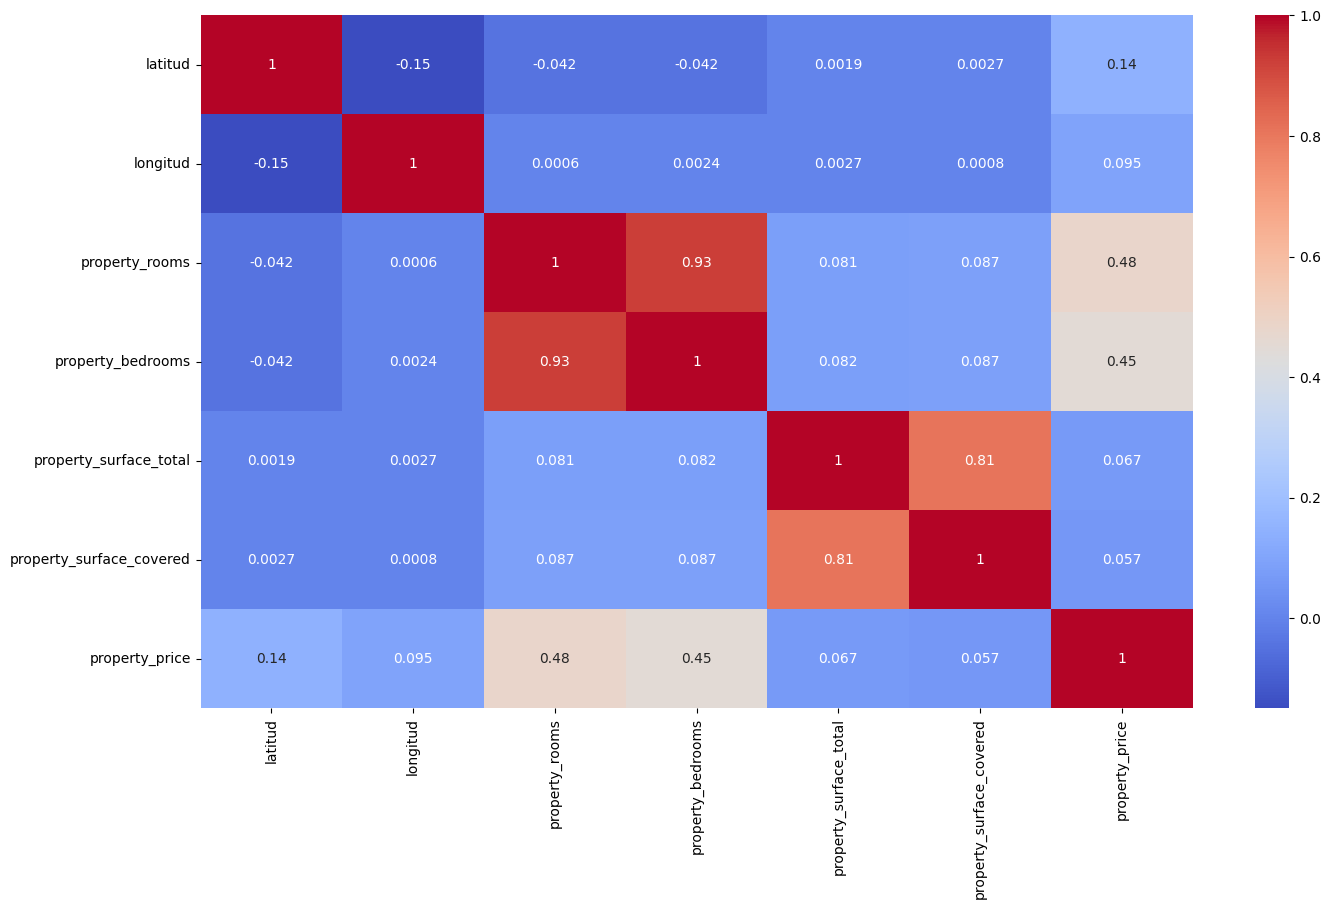

In [4]:
plt.figure(figsize = (16,9))
sns.heatmap(df.corr(), annot = True, cmap='coolwarm')

Analizando el heatmap de las correlaciones del dataset, las mejores variables predictoras para el precio por propiedad son property_rooms y property_bedrooms (ambos con valores de correlación similares dado quesi vemos la correlación entre property_room y property_bedrooms es 0.93).

In [5]:
#selecciono variables regresoras y a predecir
X = df[['property_rooms', 'property_bedrooms']]
y = df[['property_price']]

#Separacion Train/test  (80/20) según lo pedido
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=2)

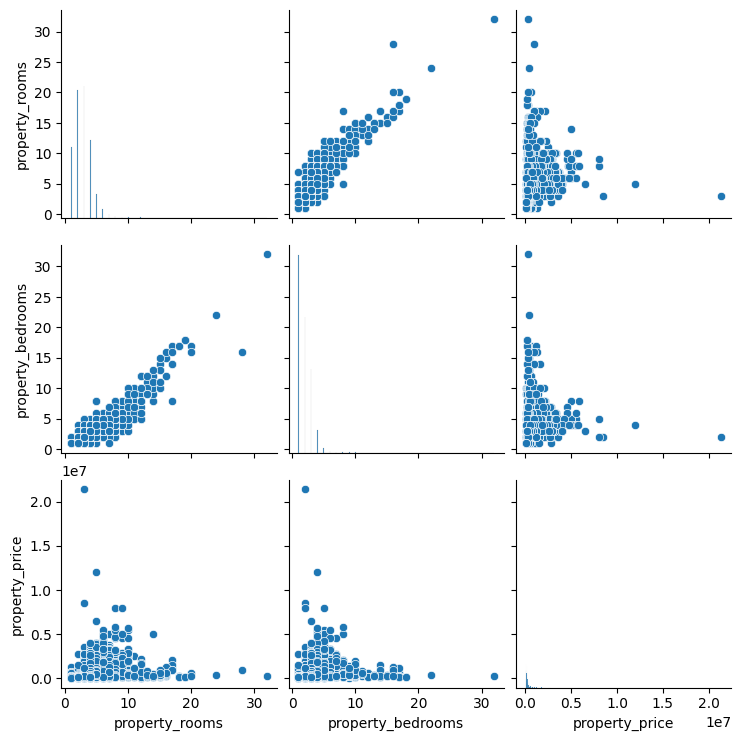

In [6]:
#Grafico de a pares incluyendo property_price y las variables predictoras
xy_train = pd.concat([X_train, y_train], axis=1)
sns.pairplot(xy_train)

En el gráfico de a pares, no se observa mucha relación lineal entre cada par (predictora, precio)

### KNN

In [7]:
#Creamos el modelo
knn = KNeighborsRegressor()

#Miramos los parámetros por defecto
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [8]:
#Entrenamos el modelo
knn.fit(X_train, y_train)

#Predicción sobre test
y_pred = knn.predict(X_test)

print('Predicciones correctas: ', np.sum(y_test == y_pred))
print('Total: ', len(y_test))


Predicciones correctas:  property_price    0
dtype: int64
Total:  16533


In [9]:
# Evaluación de la predicción
performance = pd.DataFrame(data=y_pred,columns=['Predicción'])
performance['Valor Real'] = y_test
performance['Predicción'] = y_pred
performance['Error'] = (y_test - y_pred).abs()
performance



,Predicción,Valor Real,Error
0,305380.0,210000.0,95380.0
1,126641.6,82900.0,84500.0
2,167400.0,NaN,NaN
3,167400.0,NaN,NaN
4,167400.0,250000.0,44000.0
...,...,...,...
16528,126641.6,NaN,NaN
16529,167400.0,NaN,NaN
16530,170200.0,NaN,NaN
16531,305380.0,NaN,NaN


Se observa que hay valores bien aproximados (error de 1260 por ejemplo, pero otros con mala aproximación 126000 de diferencia)

In [10]:
performance.Error.max()

9594620.0

In [11]:
performance[performance.Error > 2000000]

,Predicción,Valor Real,Error
196,167400.0,9900000.0,9594620.0
1277,126641.6,2990000.0,2403400.0
2325,294000.0,3600000.0,3147400.0
4049,167400.0,2800000.0,2315600.0
8058,167400.0,3300000.0,2847400.0
13890,126641.6,3600000.0,2862820.0
15994,167400.0,2500000.0,2194620.0


El máximo error cometido es de 960000 una cifra muy alta y se da con una propiedad de precio muy alto, la predicción nos dice que el precio es muchísimo más bajo.

In [12]:
#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

#Coef. de Determinación R2
score_knn = knn.score(X_test, y_test)
print(f"La proporción de la varianza total explicada por la regresión (r2) es {score_knn}")

El error (mse) de test es: 64656975841.04043
El error (rmse) de test es: 254277.36006384922
La proporción de la varianza total explicada por la regresión (r2) es 0.20150593308987153


En base a los scores obtenidos, se observa que la predicción no fue buena. El error cuadrático medio se destaca por ser muy alto.





### Optimización de Hiperparámetros

In [14]:
# Variamos la cantidad de vecinos (K)

neighbors = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(1, 200,5) # vecinos desde 1 hasta 200 con intervalos de 5

for n in k_range:

    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    neighbors.append((n, int((y_test == y_pred).sum())))

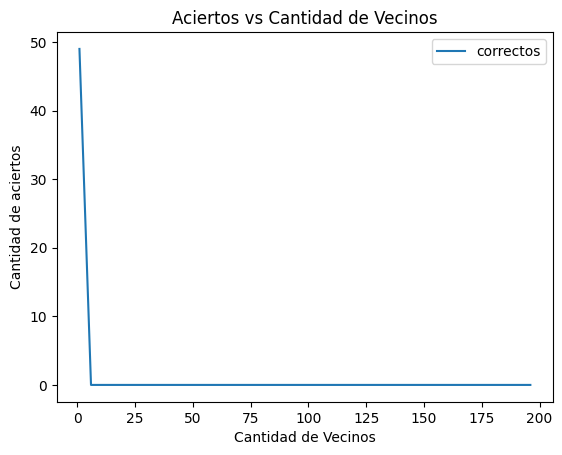

In [ ]:
# ploteamos

df_metrics = pd.DataFrame(neighbors, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

Se observa que el intervalo (1,25) podría ser un buen intervalo para buscar la mejor cantidad de vecinos 

In [ ]:
# Variamos la cantidad de vecinos (K)

neighbors = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(1, 25,1) # vecinos desde 1 hasta 25 con salto de 1

for n in k_range:

    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    neighbors.append((n, int((y_test == y_pred).sum())))

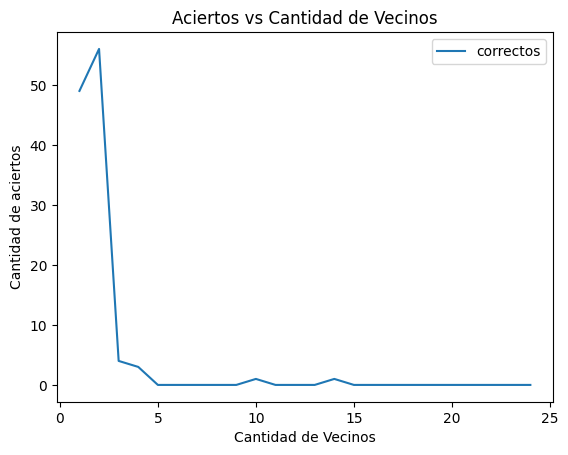

In [ ]:
# ploteamos

df_metrics = pd.DataFrame(neighbors, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

En el gráfico se observa que a partir de 10, las predicciones no son tan buenas. De igual manera se tomará la completitud del intervalo para optimizar los hiperparámetros

Métricas:

In [ ]:
list(PAIRWISE_DISTANCE_FUNCTIONS.keys())

['cityblock',
 'cosine',
 'euclidean',
 'haversine',
 'l2',
 'l1',
 'manhattan',
 'precomputed',
 'nan_euclidean']

Cosine: calcula la distancia coseno entre un par de puntos, la misma se calcula como 1 - K(X, Y) = <X, Y> / (||X||*||Y||)

Euclidean: calcula la distancia euclidea entre cada par de puntos, se calcula como sqrt(||X-Y||)

Harvesine: calcula la distancia entre dos puntos en la superficie de una esfera asumiendo que la primer coordenada es la latitud y la segunda la longitud en radianes.

Manhattan: Calcula la suma de los modulos de la diferencia entre las coordenadas de puntos. D(x,y) = |x1-y1| + ... + |xn-yn|

L1: Calcula la suma de los modulos de la diferencia entre las coordenadas de puntos (equivalente a distancia manhattan)

L2: Calcula la raíz cuadrada de la suma de los cuadrados de las diferencias entre las coordenadas de los puntos (equivalente a distancia euclidea)

Precomputed: Asume que X es una matriz de distancias

Nan_euclidean: Calcula la distancia euclidea, pero sin tener en cuenta los nas del vector.

En nuestro caso, descartaremos L1, L2, precomputed y nan_euclidean. Puesto que L1 y L2 es equivalente a euclidean y manhattan. x no es una matriz de distancias y no hay campos con na's.


In [ ]:
params_grid = { 'n_neighbors':range(1,25,1), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['cityblock',
              'cosine',
              'euclidean',
              'haversine',
              'manhattan',]
             }
params_grid

{'n_neighbors': range(1, 25),
 'weights': ['distance', 'uniform'],
 'algorithm': ['ball_tree', 'kd_tree', 'brute'],
 'metric': ['cityblock', 'cosine', 'euclidean', 'haversine', 'manhattan']}

In [ ]:
cantidad_tuplas = 1
for param in params_grid:
    cantidad_tuplas *= len(params_grid[param])
cantidad_tuplas

720

Se observa que hay 720 posibles juegos de parámetros a probarse.

In [ ]:
#Clasificador KNN
knn=KNeighborsRegressor()

#Random Search con 10 Folds 
grid = RandomizedSearchCV(knn, params_grid, cv=10, scoring='neg_root_mean_squared_error', n_iter=20, random_state=2)

grid.fit(X_train, y_train)
grid.cv_results_['mean_test_score']

KernelInterrupted: Execution interrupted by the Jupyter kernel.

Se decidió calcular aquel que reduzca más la raíz error cuadrático medio, otra decisión de scoring pudo ser aquel que reduzca el error cuadrático medio. Estos candidatos se eligieron en base a la regresión inicial que se hizo con el modelo sin entrenar

In [ ]:
#Mejores hiperparametros
print(grid.best_params_)
#Mejor métrica
print(grid.best_score_)

{'weights': 'uniform', 'n_neighbors': 22, 'metric': 'euclidean', 'algorithm': 'kd_tree'}
-245686.56806613476


In [ ]:
#Mejor estimador
best_knn=grid.best_estimator_

#Predicción con mejor estimador
y_pred_test=best_knn.predict(X_test)
y_pred_train=best_knn.predict(X_train)

In [ ]:
#Metricas de los modelos
r2_train = metrics.r2_score(y_train, y_pred_train)
r2_test=metrics.r2_score(y_test, y_pred_test)

print(f"El R2 del modelo para el precio en entrenamiento es: {r2_train}")
print(f"El R2 del modelo para el precio en test es: {r2_test}")

El R2 del modelo para el precio en entrenamiento es: 0.26893647259926623
El R2 del modelo para el precio en test es: 0.2288250689628939


### XGBOOST

Prueba con el modelo sin optimización de hiperparámetros:

In [ ]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
 
y_pred = xgbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("RMSE: %.2f" % (mse**(1/2.0)))

RMSE: 249905.90


Métricas:

rmse: Raíz cuadrada del error cuadrático medio

rmsle: Raíz cuarada del logaritmo del error cuadrático medio, esta métrica es útil para reducir el impacto de los outliers, pero dado que emplea la función logarítimica, puede producir un nan cuando es menor a -1 el error.

mae: Error absoluto medio

mape: Porcentaje del error absoluto medio

Existen otras métricas para XGBOOST, pero son para regresión logística, clasificación o regresión de modelos especiales.

### Optimización de Hiperparámetros

In [ ]:
params_grid = {'learning_rate':range(0,1,0.1), 
              'max_depth':range(1,25,1), 
              'subsample':range(0,1,0.1),
              'colsample_bytree':range(0,1,0.1)
              'n_estimators':range(1,20,2)
              'objective':{'reg:linear', 'reg:squarederror','reg:squaredlogerror'}
              'eval_metric':{'rmse','rmsle','mae','mape'},
              'seed':2
}

SyntaxError: invalid syntax (552087829.py, line 5)

In [ ]:
cantidad_tuplas = 1
for param in params_grid:
    cantidad_tuplas *= len(params_grid[param])
cantidad_tuplas

720

Agregar cuantas tuplas hay

Se decidió buscar los hiperparámetros en función de aquel que mejor reduzca la raíz del error cuadrático medio.

In [ ]:
#Clasificador XGBoost
xgbr=XGBRegressor()

#Random Search con 10 Folds 
grid = RandomizedSearchCV(xgbr, params_grid, cv=10, scoring='neg_root_mean_squared_error', n_iter=20, random_state=2)

grid.fit(X_train, y_train)
grid.cv_results_['mean_test_score']

[00:42:05] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.

[00:42:07] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.

[00:42:10] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.

[00:42:12] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.

[00:42:15] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.

[00:42:17] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.

[00:42:19] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.

[00:42:22] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.



KeyboardInterrupt: 

In [ ]:
#Mejores hiperparametros
print(grid.best_params_)
#Mejor métrica
print(grid.best_score_)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [ ]:
#Mejor estimador
best_xgbr=grid.best_estimator_

#Predicción con mejor estimador
y_pred_train=best_xgbr.predict(X_train)
y_pred_test=best_xgbr.predict(X_test)

In [ ]:
#Metricas de los modelos
r2_train = metrics.r2_score(y_train, y_pred_train)
r2_test=metrics.r2_score(y_test, y_pred_test)

print(f"El R2 del modelo para el precio en entrenamiento es: {r2_train}")
print(f"El R2 del modelo para el precio en test es: {r2_test}")

### Ridge

Como método adicional para regresión, fue elegida el modelo regresor Ridge.
La Regresión Rigde, se diferencia de la regresión lineal dado que regulariza el modelo resultante imponiendo una penalización al tamaño de los coeficientes de la relación lineal entre las características predictivas y la variable objetivo. En este caso, los coeficientes calculados minimizan la suma de los cuadrados de los residuos penalizada al añadir el cuadrado de la norma L2 del vector formado por los coeficientes

Utiliza α como parámetro de regularización y cuando es es igual a cero, Ridge es equivalente a la regresión lineal.

Métricas:

R2

RMSE

RME

Explicadas anteriormente

In [ ]:
x_train_norm = StandardScaler().fit_transform(X_train)
x_test_norm=StandardScaler().fit_transform(X_test)


In [ ]:

#Construyo un modelo Ridge  
ridge = RidgeCV()

#Lo entreno con los datos
ridge.fit(X_train, y_train)

#Hago la prediccion y calculo las métricas
y_pred=ridge.predict(X_test)
y_pred

array([[132038.25348245],
       [230994.31282175],
       [329950.37216105],
       ...,
       [ 41119.6954512 ],
       [132038.25348245],
       [230994.31282175]])

In [ ]:
params_grid={'alphas':range(1,100,5)
}

In [ ]:
#Clasificador Ridge
ridge=RidgeCV()

#Random Search con 10 Folds 
grid = RandomizedSearchCV(ridge, params_grid, cv=10, scoring='neg_root_mean_squared_error', n_iter=20, random_state=2)

grid.fit(X_train, y_train)
grid.cv_results_['mean_test_score']

array([-245523.44712516, -245523.45447117, -245523.46247088,
       -245523.47112284, -245523.48042435, -245523.49037265,
       -245523.50096496, -245523.51219856, -245523.5240707 ,
       -245523.53657866, -245523.54971971, -245523.56349118,
       -245523.57789036, -245523.59291457, -245523.60856117,
       -245523.6248275 , -245523.64171091, -245523.65920878,
       -245523.6773185 , -245523.69603747])

In [ ]:
#Mejor estimador
best_ridge=grid.best_estimator_

#Predicción con mejor estimador
y_pred_test=best_ridge.predict(X_test)
y_pred_train=best_ridge.predict(X_train)

In [ ]:
#Metricas de los modelos
r2_train = metrics.r2_score(y_train, y_pred_train)
r2_test=metrics.r2_score(y_test, y_pred_test)

print(f"El R2 del modelo para el precio en entrenamiento es: {r2_train}")
print(f"El R2 del modelo para el precio en test es: {r2_test}")

AttributeError: 'list' object has no attribute 'r2_score'

Se observa que ambos valores son más cercanos a 0 que 1, por lo que no se ajustan tanto a la variabilidad de los datos.

In [ ]:
print("MSE train: " + str(metrics.mean_squared_error(y_train, y_pred_train, squared=True)))
print("RMSE train: " + str(metrics.mean_squared_error(y_train, y_pred_train, squared=False)))

AttributeError: 'list' object has no attribute 'mean_squared_error'

In [ ]:
print("MSE test: " + str(metrics.mean_squared_error(y_test, y_pred_test, squared=True)))
print("RMSE test: " + str(metrics.mean_squared_error(y_test, y_pred_test, squared=False)))

MSE test: 69231398961.78537
RMSE test: 263118.6024624359


Se observa que la performance en train fue superior también que en test en términos de error cuadrático medio.

### REGRESION DF_PCA

In [ ]:
#Se agrega la columna de precios('property_price') al dataset 'df_pca' con los datos extraidos del dataset 'df'.
precios = df.property_price
df_pca['property_price'] = precios

<AxesSubplot: >

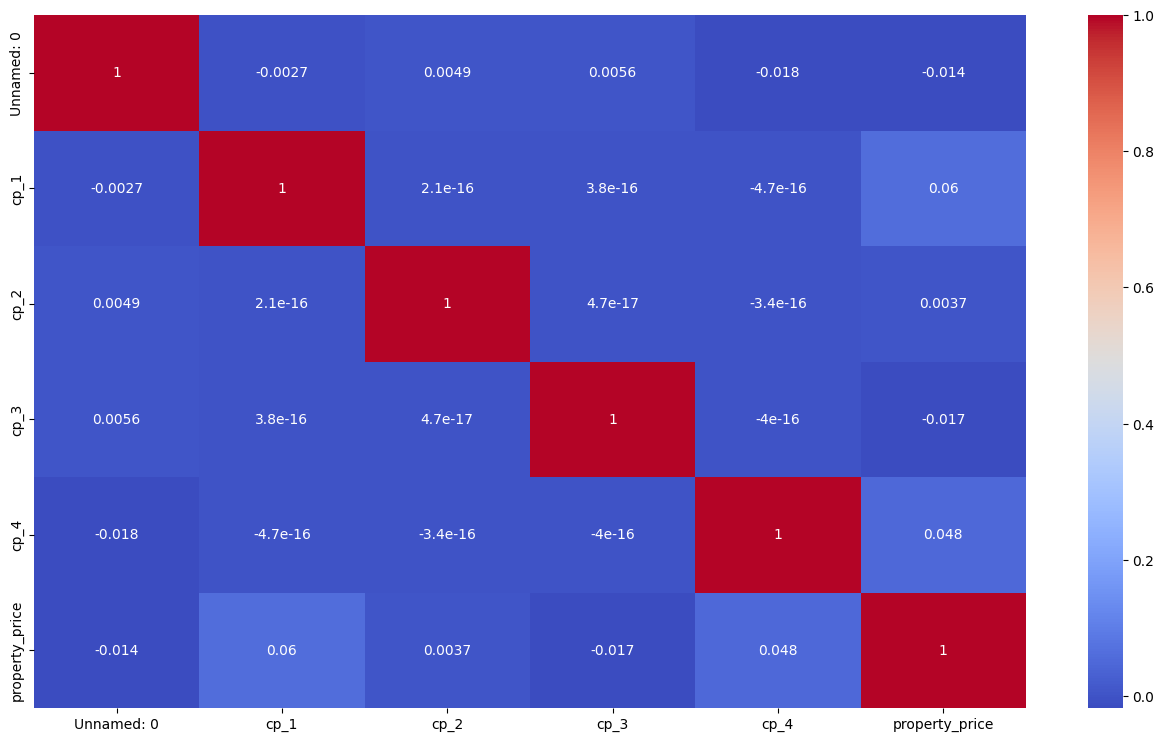

In [ ]:
plt.figure(figsize = (16,9))
sns.heatmap(df_pca.corr(), annot = True, cmap='coolwarm')

In [ ]:
#selecciono variables regresoras y a predecir
X = df_pca[['cp_1', 'cp_2']]
y = df_pca[['property_price']]

#Separacion Train/test  (80/20) según lo pedido
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=2)

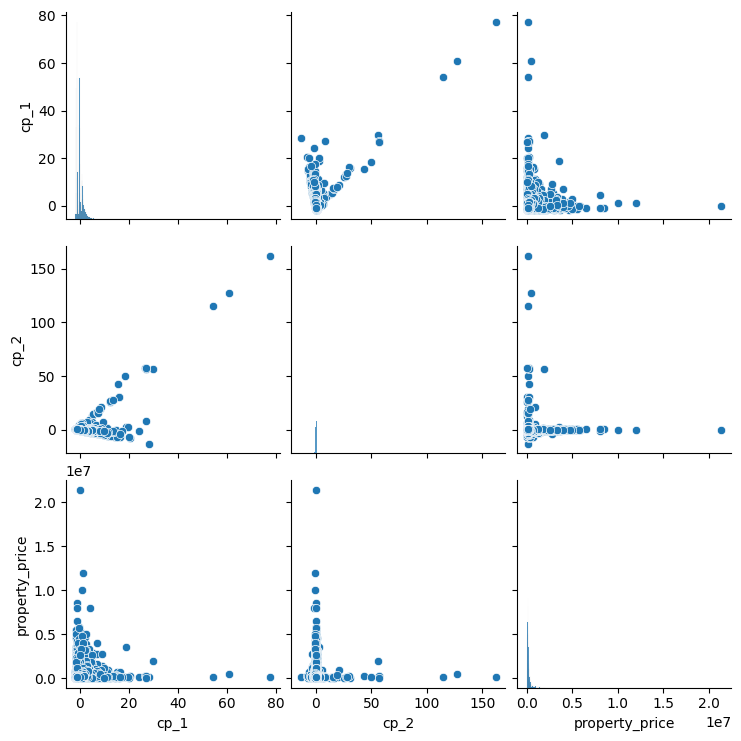

In [ ]:
#Grafico de a pares incluyendo property_price y las variables predictoras
xy_train = pd.concat([X_train, y_train], axis=1)
sns.pairplot(xy_train)

### KNN - PCA

In [ ]:
#Creamos el modelo
knn = KNeighborsRegressor()

#Miramos los parámetros por defecto
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
#Entrenamos el modelo
knn.fit(X_train, y_train)

#Predicción sobre test
y_pred = knn.predict(X_test)

print('Predicciones correctas: ', np.sum(y_test == y_pred))
print('Total: ', len(y_test))

Predicciones correctas:  property_price    3
dtype: int64
Total:  16529


In [ ]:
# Evaluación de la predicción
performance = pd.DataFrame(data=y_pred,columns=['Predicción'])
performance['Valor Real'] = y_test
performance['Predicción'] = y_pred
performance['Error'] = (y_test - y_pred).abs()
performance

,Predicción,Valor Real,Error
0,143414.2,210000.0,62580.0
1,98200.0,82900.0,104300.0
2,299800.0,NaN,NaN
3,313400.0,NaN,NaN
4,213100.0,250000.0,12580.0
...,...,...,...
16524,189970.0,NaN,NaN
16525,225600.0,NaN,NaN
16526,109380.0,NaN,NaN
16527,253000.0,NaN,NaN


Se observa que hay valores bien aproximados (error de 1260 por ejemplo, pero otros con mala aproximación 126000 de diferencia)

In [ ]:
performance.Error.max()

9359200.0

In [ ]:
performance[performance.Error > 2000000]

,Predicción,Valor Real,Error
196,134200.0,9900000.0,9359200.0
1277,331600.0,2990000.0,2705620.0
2325,165000.0,3600000.0,3433000.0
4049,182180.0,2800000.0,2673600.0
4740,241980.0,2200000.0,2074040.0
6646,201600.0,108000.0,4341580.0
8058,181580.0,3300000.0,3043400.0
13890,142000.0,3600000.0,3112800.0
15994,99780.0,2500000.0,2362020.0


El máximo error cometido es de 9359200 una cifra muy alta.

In [ ]:
#Mean Square Error
mse = metrics.mean_squared_error(y_true  = y_test, y_pred  = y_pred, squared = True)

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(y_true  = y_test, y_pred  = y_pred, squared = False)

print(f"El error (rmse) de test es: {rmse}")

#Coef. de Determinación R2
score_knn = knn.score(X_test, y_test)
print(f"La proporción de la varianza total explicada por la regresión (r2) es {score_knn}")

AttributeError: 'list' object has no attribute 'mean_squared_error'

## Optimización de Hiperparámetros

In [ ]:
# Variamos la cantidad de vecinos (K)

neighbors = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(1, 200,5) # vecinos desde 1 hasta 200 con intervalos de 5

for n in k_range:

    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    neighbors.append((n, int((y_test == y_pred).sum())))

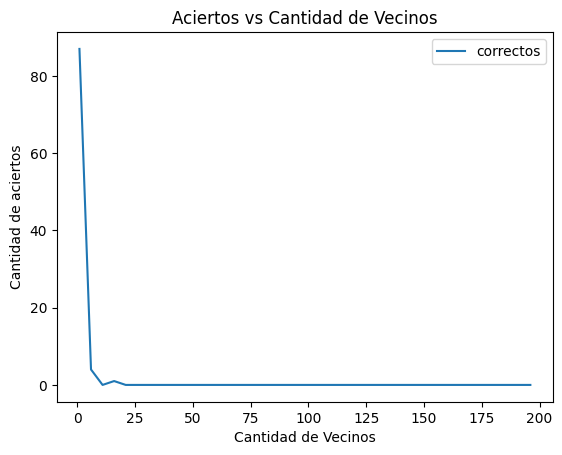

In [ ]:
# ploteamos

df_metrics = pd.DataFrame(neighbors, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

En el gráfico se observa que a partir de 25 las predicciones no son tan buenas. De igual manera se tomará la completitud del intervalo para optimizar los hiperparámetros

In [ ]:
list(PAIRWISE_DISTANCE_FUNCTIONS.keys())

['cityblock',
 'cosine',
 'euclidean',
 'haversine',
 'l2',
 'l1',
 'manhattan',
 'precomputed',
 'nan_euclidean']

Cada una de estas esta explicada en el caso del dataframe 'df'.

In [ ]:
params_grid = { 'n_neighbors':range(1,25,1), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['cityblock',
              'cosine',
              'euclidean',
              'haversine',
              'manhattan',]
             }
params_grid

{'n_neighbors': range(1, 25),
 'weights': ['distance', 'uniform'],
 'algorithm': ['ball_tree', 'kd_tree', 'brute'],
 'metric': ['cityblock', 'cosine', 'euclidean', 'haversine', 'manhattan']}

In [ ]:
cantidad_tuplas = 1
for param in params_grid:
    cantidad_tuplas *= len(params_grid[param])
cantidad_tuplas

720

Tenemos 720 tuplas, es decir posibles juegos de parametros a probarse.

In [ ]:
#Clasificador KNN
knn=KNeighborsRegressor()

#Random Search con 10 Folds 
grid = RandomizedSearchCV(knn, params_grid, cv=10, scoring='neg_root_mean_squared_error', n_iter=20, random_state=2)

grid.fit(X_train, y_train)
grid.cv_results_['mean_test_score']

KeyboardInterrupt: 

In [ ]:
#Mejores hiperparametros
print(grid.best_params_)
#Mejor métrica
print(grid.best_score_)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [ ]:
#Mejor estimador
best_knn=grid.best_estimator_

#Predicción con mejor estimador
y_pred_test=best_knn.predict(X_test)
y_pred_train=best_knn.predict(X_train)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [ ]:
#Metricas de los modelos
r2_train = metrics.r2_score(y_train, y_pred_train)
r2_test=metrics.r2_score(y_test, y_pred_test)

print(f"El R2 del modelo para el precio en entrenamiento es: {r2_train}")
print(f"El R2 del modelo para el precio en test es: {r2_test}")

AttributeError: 'list' object has no attribute 'r2_score'

### XGBOOST - PCA

In [ ]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
 
y_pred = xgbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("RMSE: %.2f" % (mse**(1/2.0)))

RMSE: 276419.16


### Optimización de Hiperparámetros

In [ ]:
params_grid = {'learning_rate':range(0,1,0.1), 
              'max_depth':range(1,25,1), 
              'subsample':range(0,1,0.1),
              'colsample_bytree':range(0,1,0.1)
              'n_estimators':range(1,20,2)
              'objective':{'reg:linear', 'reg:squarederror','reg:squaredlogerror'}
              'eval_metric':{'rmse','rmsle','mae','mape'},
              'seed':2
}

SyntaxError: invalid syntax (552087829.py, line 5)

In [ ]:
cantidad_tuplas = 1
for param in params_grid:
    cantidad_tuplas *= len(params_grid[param])
cantidad_tuplas

720

Se decidió buscar los hiperparámetros en función de aquel que mejor reduzca la raíz del error cuadrático medio.

In [ ]:
#Clasificador XGBoost
xgbr=XGBRegressor()

#Random Search con 10 Folds 
grid = RandomizedSearchCV(xgbr, params_grid, cv=10, scoring='neg_root_mean_squared_error', n_iter=20, random_state=2)

grid.fit(X_train, y_train)
grid.cv_results_['mean_test_score']

[23:58:32] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.

[23:58:34] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.

[23:58:37] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.

[23:58:39] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.

[23:58:42] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.

[23:58:44] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.

[23:58:46] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.

[23:58:49] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.

[23:58:52] WARNI

KeyboardInterrupt: 

In [ ]:
#Mejores hiperparametros
print(grid.best_params_)
#Mejor métrica
print(grid.best_score_)

In [ ]:
#Mejor estimador
best_xgbr=grid.best_estimator_

#Predicción con mejor estimador
y_pred_train=best_xgbr.predict(X_train)
y_pred_test=best_xgbr.predict(X_test)

In [ ]:
#Metricas de los modelos
r2_train = metrics.r2_score(y_train, y_pred_train)
r2_test=metrics.r2_score(y_test, y_pred_test)

print(f"El R2 del modelo para el precio en entrenamiento es: {r2_train}")
print(f"El R2 del modelo para el precio en test es: {r2_test}")

### Ridge - PCA

Como Rodge se eligió como método adicional para regresión, a continuacion haremos uso para el caso de PCA

Métricas:

R2

RMSE

RME

Explicadas anteriormente

In [ ]:
x_train_norm = StandardScaler().fit_transform(X_train)
x_test_norm=StandardScaler().fit_transform(X_test)

In [ ]:
#Construyo un modelo Ridge  
ridge = RidgeCV()

#Lo entreno con los datos
ridge.fit(X_train, y_train)

#Hago la prediccion y calculo las métricas
y_pred=ridge.predict(X_test)
y_pred

array([[215338.07646895],
       [215779.87286047],
       [205579.85134107],
       ...,
       [204880.43423151],
       [228995.70702946],
       [205221.397109  ]])

In [ ]:
params_grid={'alphas':range(1,100,5)}

In [ ]:
#Clasificador Ridge
ridge=RidgeCV()

#Random Search con 10 Folds 
grid = RandomizedSearchCV(ridge, params_grid, cv=10, scoring='neg_root_mean_squared_error', n_iter=20, random_state=2)

grid.fit(X_train, y_train)
grid.cv_results_['mean_test_score']

array([-286965.63514476, -286965.63391636, -286965.63268904,
       -286965.63146281, -286965.63023767, -286965.62901362,
       -286965.62779067, -286965.62656881, -286965.62534804,
       -286965.62412836, -286965.62290978, -286965.62169228,
       -286965.62047588, -286965.61926057, -286965.61804635,
       -286965.61683322, -286965.61562118, -286965.61441023,
       -286965.61320037, -286965.6119916 ])

In [ ]:
#Mejor estimador
best_ridge=grid.best_estimator_

#Predicción con mejor estimador
y_pred_test=best_ridge.predict(X_test)
y_pred_train=best_ridge.predict(X_train)

In [ ]:
#Metricas de los modelos
r2_train = metrics.r2_score(y_train, y_pred_train)
r2_test=metrics.r2_score(y_test, y_pred_test)

print(f"El R2 del modelo para el precio en entrenamiento es: {r2_train}")
print(f"El R2 del modelo para el precio en test es: {r2_test}")

AttributeError: 'list' object has no attribute 'r2_score'

In [ ]:
print("MSE train: " + str(metrics.mean_squared_error(y_train, y_pred_train, squared=True)))
print("RMSE train: " + str(metrics.mean_squared_error(y_train, y_pred_train, squared=False)))

AttributeError: 'list' object has no attribute 'mean_squared_error'

In [ ]:
print("MSE test: " + str(metrics.mean_squared_error(y_test, y_pred_test, squared=True)))
print("RMSE test: " + str(metrics.mean_squared_error(y_test, y_pred_test, squared=False)))

AttributeError: 'list' object has no attribute 'mean_squared_error'

Se observa que la performance en train fue superior también que en test en términos de error cuadrático medio.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0cf69c3d-aa8c-478a-9384-e5da0f7d7007' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>